In [320]:
library(popcycle)
cruise <- "SCOPE_3"
path <- "/Users/John/Documents/Armbrust/popcycle_project/"
#path <- "/Volumes/data/data/seaflow/refilter/"
db <- paste0(path,cruise, "/",cruise,".db")

In [321]:
stats <- get.stat.table(db, flag=F)
stats$time <- as.POSIXct(stats$time, format = "%FT%T", tz = "GMT")
stats$flag <- 0
sfl <- get.sfl.table(db)
sfl$date <- as.POSIXct(sfl$date, format = "%FT%T", tz = "GMT")

In [329]:
summary(stats)
summary(sfl)

    cruise              file                time                    
 Length:7985        Length:7985        Min.   :2015-05-23 01:54:11  
 Class :character   Class :character   1st Qu.:2015-05-24 00:24:03  
 Mode  :character   Mode  :character   Median :2015-05-24 23:14:04  
                                       Mean   :2015-05-24 22:07:23  
                                       3rd Qu.:2015-05-25 19:37:36  
                                       Max.   :2015-05-26 16:43:23  
                                                                    
      lat             lon         opp_evt_ratio       flow_rate   
 Min.   :21.24   Min.   :-158.0   Min.   :0.01082   Min.   :1786  
 1st Qu.:22.70   1st Qu.:-158.0   1st Qu.:0.01658   1st Qu.:2278  
 Median :22.75   Median :-157.8   Median :0.01755   Median :2278  
 Mean   :22.54   Mean   :-157.3   Mean   :0.01741   Mean   :2277  
 3rd Qu.:22.75   3rd Qu.:-156.1   3rd Qu.:0.01836   3rd Qu.:2278  
 Max.   :22.87   Max.   :-156.0   Max.   :0.02

    cruise              file                date                    
 Length:1789        Length:1789        Min.   :2015-05-22 22:53:01  
 Class :character   Class :character   1st Qu.:2015-05-23 21:41:07  
 Mode  :character   Mode  :character   Median :2015-05-24 20:01:48  
                                       Mean   :2015-05-24 19:55:21  
                                       3rd Qu.:2015-05-25 18:22:30  
                                       Max.   :2015-05-26 16:43:23  
                                                                    
 file_duration        lat             lon          conductivity 
 Min.   :  0.0   Min.   :21.24   Min.   :-158.0   Min.   : NA   
 1st Qu.:180.1   1st Qu.:22.51   1st Qu.:-158.0   1st Qu.: NA   
 Median :180.1   Median :22.75   Median :-157.8   Median : NA   
 Mean   :179.6   Mean   :22.50   Mean   :-157.3   Mean   :NaN   
 3rd Qu.:180.1   3rd Qu.:22.75   3rd Qu.:-156.1   3rd Qu.: NA   
 Max.   :190.3   Max.   :22.87   Max.   :-156.0   Max.   :

ERROR: Error in c(1, ): argument 2 is empty


## Remove the 'Obvious' Outliers with Flow Rate
Namely, outliers detected from the flow rate. Since the experiemtnal value of the flow rate should be a constant, these are the easiest outliers to throw away.

We can do this with cook's distance:

In [322]:
model <- lm(flow_rate ~ time, data=stats)
cooks.distance <- cooks.distance(model)
# Files with significant influence on the linear model
cooks.stats <- as.numeric(names(cooks.distance)[(cooks.distance > mean(cooks.distance, na.rm=T))])
stats <- stats[-c(cooks.sfl),]

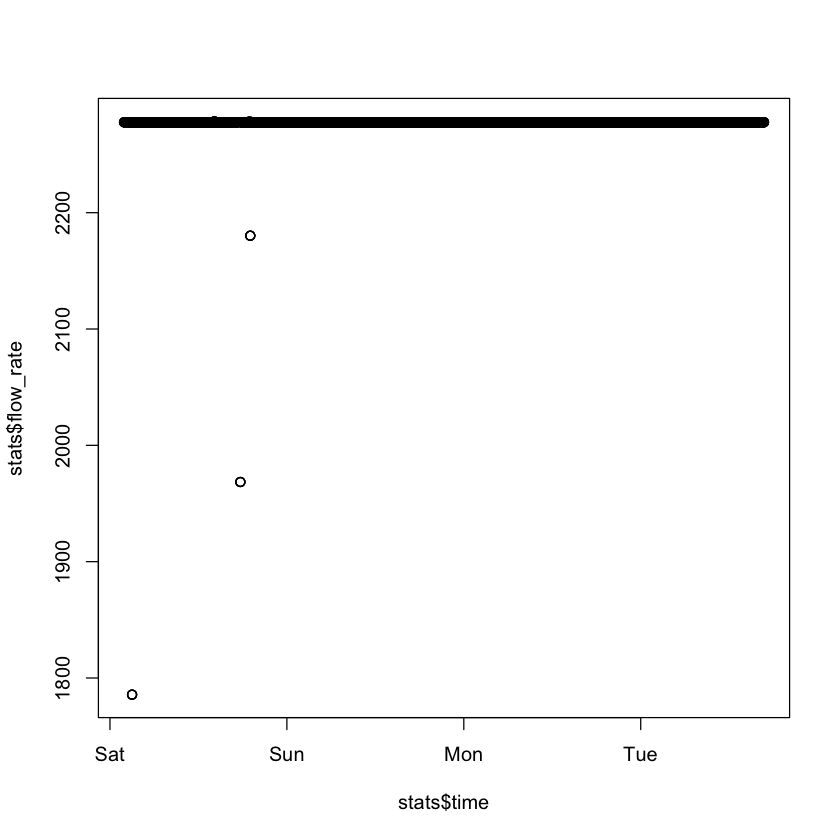

In [323]:
plot(stats$time, stats$flow_rate)

## Re-examine the data
There are a lot of paramaters for each data point collected. We have already successfully ruled out all of the outliers due to flow_rate. The parameters we now want to focus on are:

1. time
2. opp_evt_ratio
3. abundance
4. fsc_small_mean
5. chl_small_mean
6. pe_mean

Let's re-group our data into a subset of these parameters. 
We will also include "files", and "pop" (population), to help keep track of our data

In [305]:
params <- c("file", "time", "opp_evt_ratio", "pop", "abundance", 
            "fsc_small_mean", "chl_small_mean", "pe_mean")
data <- stats[params]
summary(data)

     file                time                     opp_evt_ratio     
 Length:1662        Min.   :2014-12-09 05:50:25   Min.   :0.005426  
 Class :character   1st Qu.:2014-12-09 11:02:46   1st Qu.:0.008531  
 Mode  :character   Median :2014-12-09 15:57:11   Median :0.008866  
                    Mean   :2014-12-09 15:32:24   Mean   :0.008918  
                    3rd Qu.:2014-12-09 20:07:22   3rd Qu.:0.009358  
                    Max.   :2014-12-10 00:15:03   Max.   :0.010074  
     pop              abundance        fsc_small_mean    chl_small_mean    
 Length:1662        Min.   :  0.0336   Min.   :  3.778   Min.   :   6.519  
 Class :character   1st Qu.:  3.6774   1st Qu.: 51.772   1st Qu.:   9.714  
 Mode  :character   Median :  5.1652   Median :109.439   Median :  40.539  
                    Mean   : 71.2072   Mean   :311.081   Mean   : 207.491  
                    3rd Qu.: 20.0075   3rd Qu.:581.509   3rd Qu.: 133.828  
                    Max.   :419.2484   Max.   :915.847   Max.

Now make subsets of the data frame to represent each population. (For simplicity I'm only going to do prochloro)

In [306]:
pro <- data[(data$pop=="prochloro"),]

Let's look at all of the data as a time series

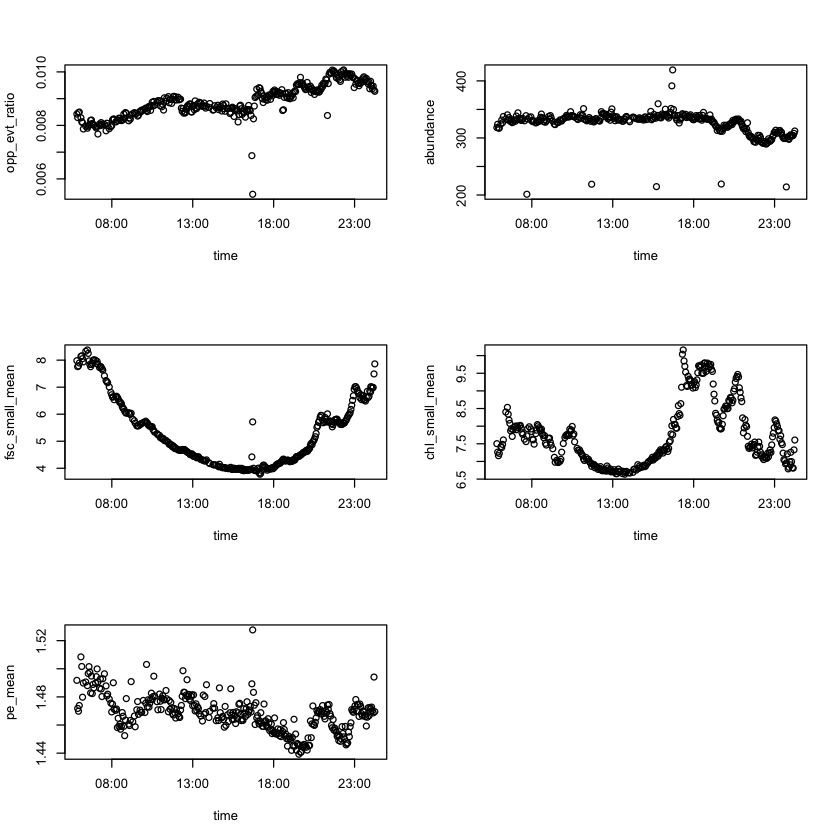

In [307]:
par(mfrow=c(3,2))
plot(pro$time, pro$opp_evt_ratio, xlab="time", ylab="opp_evt_ratio")
plot(pro$time, pro$abundance, xlab="time", ylab="abundance")
plot(pro$time, pro$fsc_small_mean, xlab="time", ylab="fsc_small_mean")
plot(pro$time, pro$chl_small_mean, xlab="time", ylab="chl_small_mean")
plot(pro$time, pro$pe_mean, xlab="time", ylab="pe_mean")

## Now let's examine the Mahalanobis distance

In [317]:
pro$time <- as.numeric(pro$time)
pro.numeric1 = pro[,c("opp_evt_ratio", "abundance")]
pro.numeric2 = pro[,c("opp_evt_ratio", "fsc_small_mean")]
pro.numeric3 = pro[,c("opp_evt_ratio", "abundance", "fsc_small_mean")]
pro.numeric4 = pro[,c("abundance", "fsc_small_mean")]
pro.numeric5 = pro[,c("opp_evt_ratio", "abundance", "fsc_small_mean", "chl_small_mean",
                     "pe_mean")]

In [309]:
maha <- function(data) {
    center <- colMeans(data)
    cov <- cov(data)
    maha <- mahalanobis(data, center, cov)
    return(maha)
}

In [318]:
maha1 <- maha(pro.numeric1)
maha2 <- maha(pro.numeric2)
maha3 <- maha(pro.numeric3)
maha4 <- maha(pro.numeric4)
maha5 <- maha(pro.numeric5)

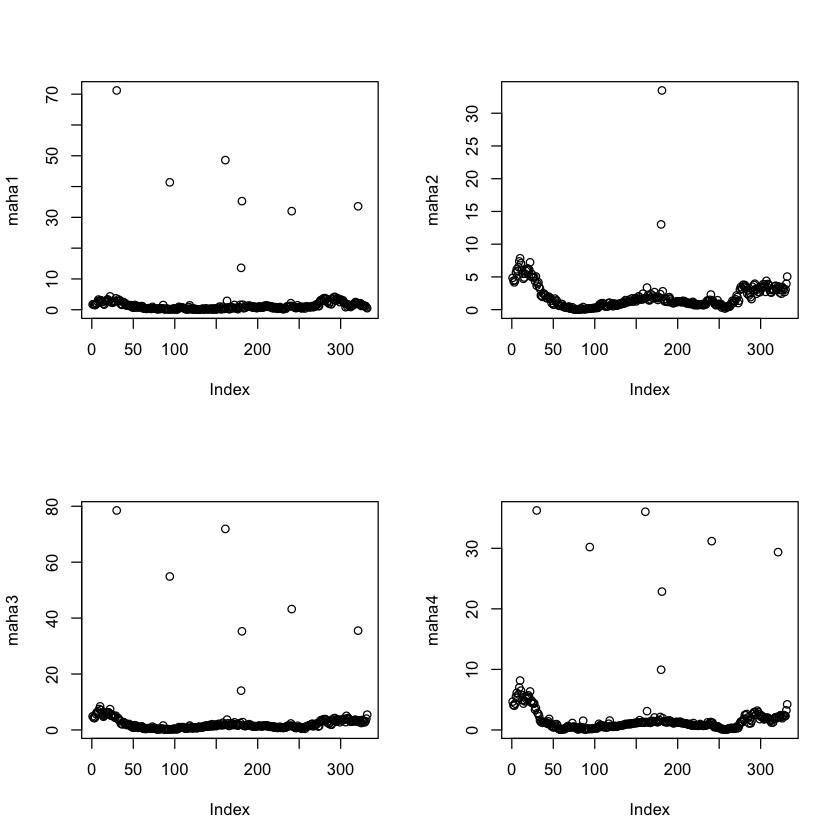

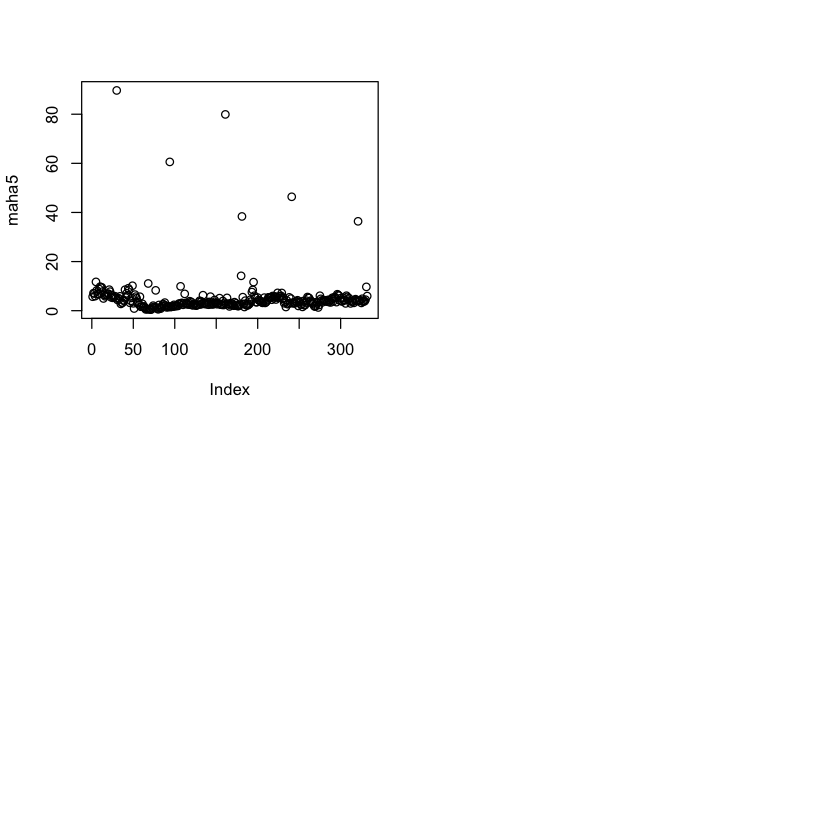

In [319]:
par(mfrow=c(2,2))
plot(maha1)
plot(maha2)
plot(maha3)
plot(maha4)
plot(maha5)

In [284]:
cutoff <- qchisq(.99, 3)
cutoff

[1] 11.34487

In [287]:
pro <- pro[maha < cutoff,]

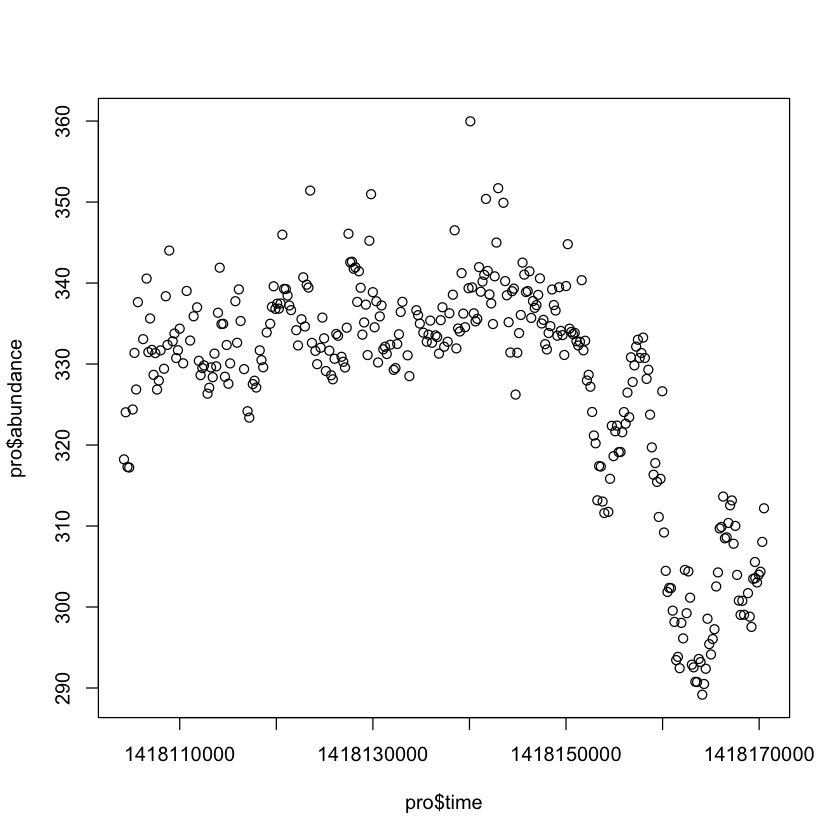

In [288]:
plot(pro$time, pro$abundance)